<a href="https://colab.research.google.com/github/YuxingW/deep_learning/blob/main/hw6/part_b_keras_multilabel_image_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Keras Multilabel Image classification


## Introduction

The dataset has 5 categies of images: "desert", "mountains", "sea", "sunset", "trees".


## Load the data

### Raw data download

First, let's download the ZIP archive of the raw data: <br />
The zip file is also shared in google drive: https://drive.google.com/file/d/11RV5Inkb2b6TAS1re36CsLS9qMVyOkRB/view?usp=sharing


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
! ls drive/MyDrive/*.zip

drive/MyDrive/miml_dataset.zip


In [12]:
!unzip -q drive/MyDrive/miml_dataset.zip
!ls


drive  miml_dataset  sample_data


Now we have a `miml_dataset` folder which contain one subfolder `images`, which contains image files for each category.


In [13]:
!ls miml_dataset/


images	miml_labels_1.csv  miml_labels_2.csv


In [14]:
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np

##Standardizing the data
Also split the data to 3 parts, training validation and test.

In [15]:
df=pd.read_csv("./miml_dataset/miml_labels_1.csv")
columns=["desert", "mountains", "sea", "sunset", "trees"]
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)
train_generator=datagen.flow_from_dataframe(
      dataframe=df[:1800],
      directory="./miml_dataset/images",
      x_col="Filenames",
      y_col=columns,
      batch_size=32,
      seed=42,
      shuffle=True,
      class_mode="raw",
      target_size=(100,100))
valid_generator=test_datagen.flow_from_dataframe(
      dataframe=df[1800:1900],
      directory="./miml_dataset/images",
      x_col="Filenames",
      y_col=columns,
      batch_size=32,
      seed=42,
      shuffle=True,
      class_mode="raw",
      target_size=(100,100))
test_generator=test_datagen.flow_from_dataframe(
      dataframe=df[1900:],
      directory="./miml_dataset/images",
      x_col="Filenames",
      batch_size=1,
      seed=42,
      shuffle=False,
      class_mode=None,
      target_size=(100,100))


Found 1800 validated image filenames.
Found 100 validated image filenames.
Found 100 validated image filenames.


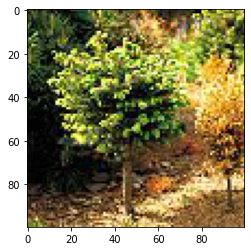

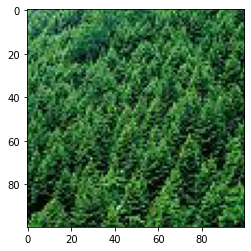

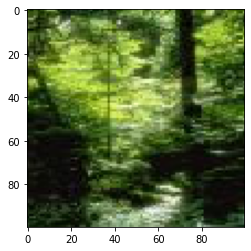

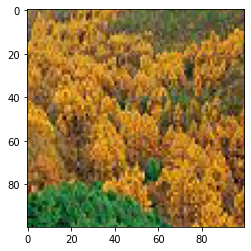

In [30]:
import matplotlib.pyplot as plt

x,y = valid_generator.next()
for i in range(0,4):
    image = x[i]
    plt.imshow(image)
    plt.show()

## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
 configuration, consider using
[Keras Tuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `Conv2D` layer with padding.
- We include `Dropout` layers before the Conv2D layer and the final classification layer.
- We have the 5 outputs in Dense layer for multilabel prediction.


In [16]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(100,100,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='sigmoid'))
model.compile(optimizers.RMSprop(lr=0.0001, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy"])

## Train the model


In [17]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
56/56 [==============================] - 83s 1s/step - loss: 0.5601 - accuracy: 0.3267 - val_loss: 0.4731 - val_accuracy: 0.3958
Epoch 2/10
56/56 [==============================] - 81s 1s/step - loss: 0.4258 - accuracy: 0.5468 - val_loss: 0.3161 - val_accuracy: 0.7500
Epoch 3/10
56/56 [==============================] - 81s 1s/step - loss: 0.4040 - accuracy: 0.5768 - val_loss: 0.3353 - val_accuracy: 0.6771
Epoch 4/10
56/56 [==============================] - 81s 1s/step - loss: 0.3733 - accuracy: 0.6033 - val_loss: 0.4082 - val_accuracy: 0.6250
Epoch 5/10
56/56 [==============================] - 82s 1s/step - loss: 0.3467 - accuracy: 0.6339 - val_loss: 0.3146 - val_accuracy: 0.6667
Epoch 6/10
56/56 [==============================] - 81s 1s/step - loss: 0.3527 - accuracy: 0.6160 - val_loss: 0.2265 - val_accuracy: 0.7396
Epoch 7/10
56/56 [==============================] - 81s 1s/step - loss: 0.3443 - accuracy: 0.6423 - val_loss: 0.2850 - val_accuracy: 0.6979
Epoch 8/10
56/56 [==

## Run inference on test data

Note we need to reset the test_generator before whenever we call the predict_generator.


In [18]:
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

  1/100 [..............................] - ETA: 13s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


100/100 [==============================] - 2s 20ms/step


In [19]:
pred_bool = (pred >0.5)

In [20]:
predictions = pred_bool.astype(int)
columns=["desert", "mountains", "sea", "sunset", "trees"]
#columns should be the same order of y_col
results=pd.DataFrame(predictions, columns=columns)
results["Filenames"]=test_generator.filenames
ordered_cols=["Filenames"]+columns
results=results[ordered_cols]#To get the same column order
results.head()

,Filenames,desert,mountains,sea,sunset,trees
0,1901.jpg,0,0,1,0,1
1,1902.jpg,0,0,1,0,0
2,1903.jpg,0,0,0,0,1
3,1904.jpg,0,0,1,0,0
4,1905.jpg,0,0,0,0,1


In [21]:
# A simple function for visualization.
def show_sample(img, binary_img_labels):
    # Convert the binary labels back to the text representation.    
    img_labels = np.array(dataset_val.classes)[np.argwhere(binary_img_labels > 0)[:, 0]]
    plt.imshow(img)
    plt.title("{}".format(', '.join(img_labels)))
    plt.axis('off')
    plt.show()

for sample_id in range(5):
    show_sample('miml_dataset/images/' + results['Filenames'], results['sea']

We get to ~70% validation accuracy after training for 56 epochs on the full dataset.
